## socketIO

* 与Javascript， Swift， C ++和 Java官方Socket.IO客户端以及符合Socket.IO规范的任何第三方客户端完全兼容 。
* 兼容Python 2.7和Python 3.3+。
* 当与基于asyncio （sanic，aiohttp或 tornado）， eventlet或gevent的异步服务器一起使用时，即使在适度硬件上也支持大量客户端。对于开发和测试，也可以使用任何符合WSGI的多线程服务器。
* 将消息广播到所有连接的客户端，或分配给“房间”的子集。
* 基于事件的架构使用装饰器实现，隐藏了协议的细节。
* 支持HTTP长轮询和WebSocket传输。
* 支持XHR2和XHR浏览器。
* 支持文本和二进制消息。
* 支持gzip和deflate HTTP压缩。
* 可配置的CORS响应，以避免浏览器的跨源问题。

### 什么是Socket.IO？
Socket.IO是一种传输协议，可在客户端（通常是Web浏览器）和服务器之间实现基于事件的双向事件通信。客户端和服务器组件的原始实现是用JavaScript编写的。

In [2]:
%%writefile socketServer.py
import socketio
import eventlet

#实例化socketio实例化话对象
sio = socketio.Server()


#@sio.on()监听什么事件
@sio.on('connect')
def connect(sid, environ):
    print('connect ', sid)
    sio.emit('addChat',sid)

@sio.on('message')
def message(sid, data):
    print('message ', data)
    #发送消息，emit,发送事件名称，第二个参数是数据，关键词参数room，用来发给具体的某个人，如果没有设置那么久发给所有监听这个事件的人
    sio.emit('reply',{'message':'hello','sid':sid})
    
    
@sio.on('sendMessage')
def sendMessage(sid,data):
    #data  = { 'content':"聊天信息"，destId:'cd9ab3984c5b4ab5ba7bfa1dd027626f'}
    print(data)
    sio.emit('reply',data['content'],room=data['destId'])


@sio.on('disconnect')
def disconnect(sid):
    print('disconnect ', sid)

if __name__ == '__main__':
    # sio通过middleware转为应用服务
    app = socketio.Middleware(sio)

    # 依赖eventlet网关服务器
    eventlet.wsgi.server(eventlet.listen(('', 8000)), app)

Overwriting socketServer.py


## 房间
由于Socket.IO是双向协议，因此服务器可以随时向任何连接的客户端发送消息。为了方便地处理客户端组，应用程序可以将客户端放入房间，然后将消息发送到整个房间。

当客户端首次连接时，它们被分配到自己的房间，以会话ID（sid传递给所有事件处理程序的参数）命名。该应用程序可以自由创建其他房间，并使用socketio.Server.enter_room()和 socketio.Server.leave_room()方法管理其中的客户端。客户可以根据需要在多个房间内，并且可以根据需要在房间之间移动。分别连接到客户端的各个房间在任何情况下都不是特殊的，应用程序可以自由地添加或删除客户端，但一旦这样做，它将失去对个别客户端的处理能力。

In [ ]:
@sio.on('enter room')
def enter_room(sid, data):
    sio.enter_room(sid, data['room'])

@sio.on('leave room')
def leave_room(sid, data):
    sio.leave_room(sid, data['room'])

In [ ]:
# 当向房间中的用户组广播消息时
@sio.on('my message')
def message(sid, data):
    print('message ', data)
    sio.emit('my reply', data, room='my room')

In [ ]:
# 当向房间中的用户组广播消息时，期望发送者不接收其自己的消息。可选skip_sid参数，用于指定在广播期间应跳过的客户端。
@sio.on('my message')
def message(sid, data):
    print('message ', data)
    sio.emit('my reply', data, room='my room', skip_sid=sid)

### close_room（房间，命名空间=无）
关闭一个房间。

此功能从给定的房间中删除所有客户端。

参数：	
* 房间 - 房间名称。
* namespace - 事件的Socket.IO名称空间。如果省略此参数，则使用默认命名空间。

### disconnect（sid，namespace = None ）
断开客户端连接。

参数：	
* sid - 客户端的会话ID。
* namespace - 要断开连接的Socket.IO命名空间。如果省略此参数，则使用默认命名空间。

### emit
emit（event，data = None，room = None，skip_sid = None，namespace = None，callback = None，** kwargs ）

向一个或多个连接的客户端发送自定义事件。

参数：	
* event - 事件名称。它可以是任何字符串。事件名称 'connect'，'message'并且'disconnect'被保留，不应使用。
* data - 要发送到客户端或客户端的数据。数据可以是类型的str，bytes，list或dict。如果a list或者dict，数据将被序列化为JSON。
* room - 消息的收件人。这可以设置为客户端的会话ID以解决该客户端的房间或应用程序创建的任何自定义房间。如果省略此参数，则将事件广播到所有连接的客户端。
* skip_sid - 广播到房间或所有客户端时要跳过的客户端的会话ID。这可用于防止将消息发送给发件人。
* namespace - 事件的Socket.IO名称空间。如果省略此参数，则会将事件发送到默认命名空间。
* callback - 如果给定，将调用此函数以确认客户端已收到消息。将传递给函数的参数是客户端提供的参数。回调函数只能在寻址单个客户端时使用。
* ignore_queue - 仅在配置消息队列时使用。如果设置为True，则直接将事件发送给客户端，而不通过队列。这样更有效，但仅在使用单个服务器进程时才有效。建议始终将此参数保留为其默认值False。


### enter_room（sid，room，namespace = None ）
进入一个房间。

此功能将客户端添加到房间。该emit()和 send()功能可以有选择地事件报告给所有的客户在一个房间里。

参数：	
* sid - 客户端的会话ID。
* 房间 - 房间名称。如果房间不存在则会创建。
* namespace - 事件的Socket.IO名称空间。如果省略此参数，则使用默认命名空间。

### leave_room（sid，room，namespace = None ）
离开房间。

此功能从客房中删除客户端。

参数：	
* sid - 客户端的会话ID。
* 房间 - 房间名称。
* namespace - 事件的Socket.IO名称空间。如果省略此参数，则使用默认命名空间。

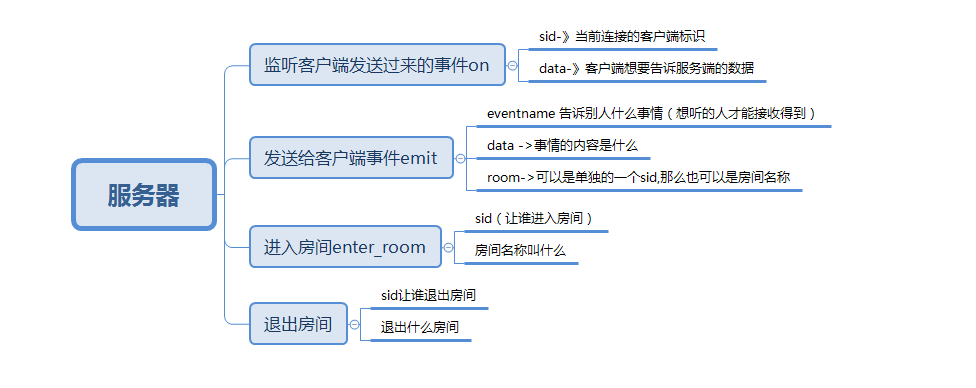

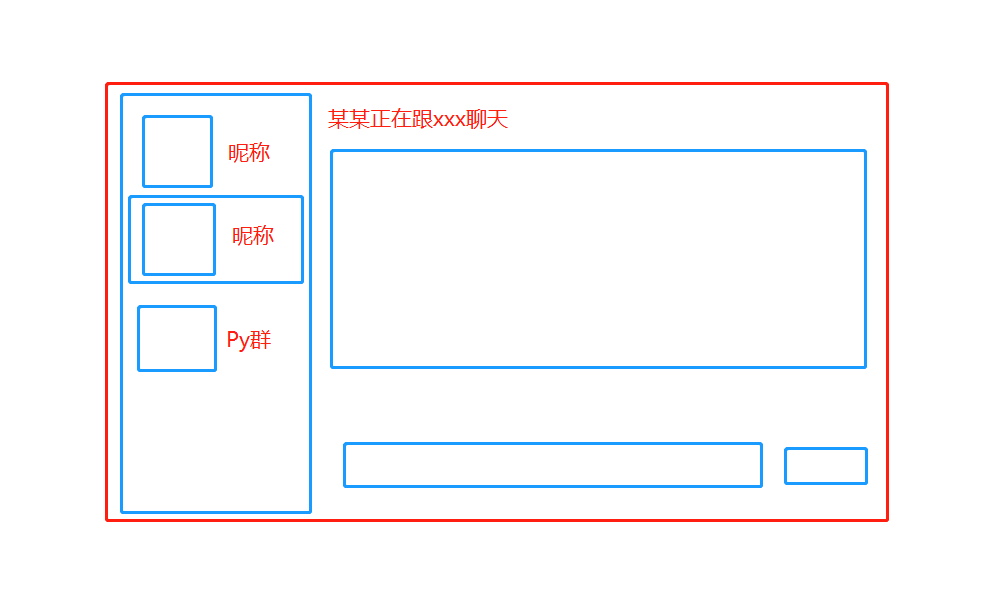